<a href="https://colab.research.google.com/github/mking2014/final-4449-king/blob/main/gender_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# def evaluate_classification_model(g_labels, g_preds):

#   cm = confusion_matrix(g_labels, g_preds)
#   sns.heatmap(cm, annot = True, fmt ='.0f')
#   plt.ylabel('True Label')
#   plt.xlabel('Predictied Label')
#   plt.title('Gender Classficiation')
#   print(f"Accuracy: {accuracy_score(g_labels, g_preds)}")
#   print(f"Precision: {precision_score(g_labels, g_preds)}")
#   print(f"Recall: {recall_score(g_labels, g_preds)}")
#   print(f"F1 Score: {f1_score(g_labels, g_preds)}")

#   return


# Load Data

0 = Male <br>
1 = Female

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/comp4449_final/content 2/data/age_gender.csv')
df = df.drop(columns = ['img_name'])
print(f"Dataset size: {df.shape}")
df.head()

Dataset size: (23705, 4)


,age,ethnicity,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,202 205 209 210 209 209 210 211 212 214 218 21...


In [ ]:
# Converting pixels into numpy array
df['pixels']=df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

# Data Preparation

This model will predict the age & gender usge the images. A classification model will be used to predict the gender (binary result) while a regression model will be used to predict the age.

Text(0, 0.5, 'Count')

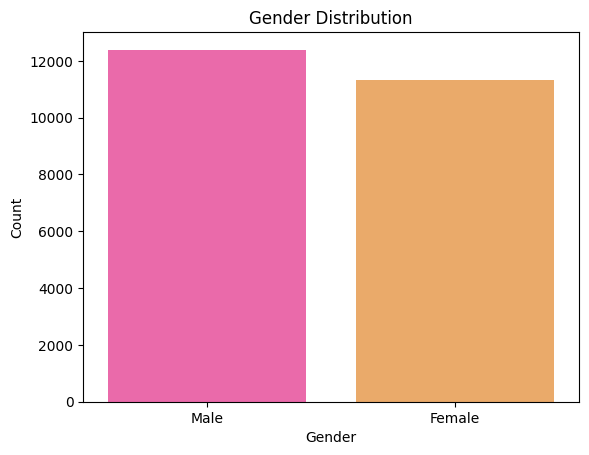

In [ ]:
sns.countplot(x="gender", palette='spring', data=df.replace({"gender" : {0 : "Male", 1 : "Female"}}))
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
df.head()

,age,ethnicity,gender,pixels
0,1,2,0,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


<Axes: xlabel='age_bin', ylabel='count'>

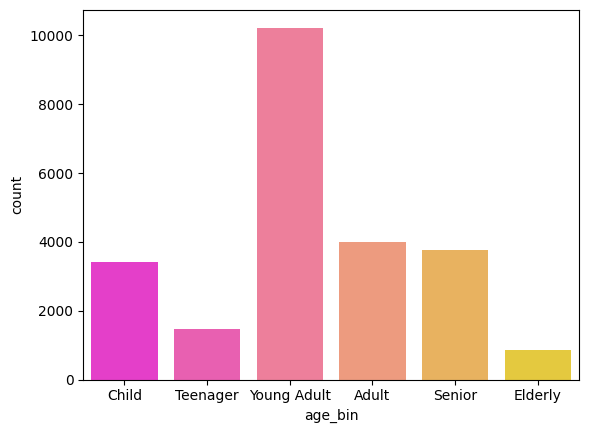

In [ ]:
bins = [0, 12, 20, 35, 50, 75, 116]
labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior', 'Elderly']
df['age_bin'] = pd.cut(x = df['age'], bins = bins, labels = labels, include_lowest = True)
df['age_bin'].value_counts()

sns.countplot(data = df, x = 'age_bin', palette = 'spring')

In [ ]:
# create label encoding for binning ages
encoder = LabelEncoder()
df['ages_encoded'] = encoder.fit_transform(df['age_bin'])
df.head()

age_mapping = dict(zip(range(len(encoder.classes_)), encoder.classes_ ))
age_mapping

{0: 'Adult',
 1: 'Child',
 2: 'Elderly',
 3: 'Senior',
 4: 'Teenager',
 5: 'Young Adult'}

In [ ]:
test, train = train_test_split(df, test_size=0.85, random_state=42)
print(train.shape)
print(test.shape)

(20150, 6)
(3555, 6)


In [ ]:
#Reshaping images in training & test datasets

X_train = train['pixels']
# normalizing pixels data
X_train = X_train/255

# reshape images
X_train = np.array(X_train.tolist())
X_train = X_train.reshape(-1,48,48, 1)
print(f"Shape of training images: {X_train.shape}")


X_test = test['pixels']
# normalizing pixels data
X_test = X_test/255

# reshape images
X_test = np.array(X_test.tolist())
X_test = X_test.reshape(-1,48,48, 1)
print(f"Shape of images: {X_test.shape}")

Shape of training images: (20150, 48, 48, 1)
Shape of images: (3555, 48, 48, 1)


In [ ]:
# create y training datasets for age regression model

y_train_age = train['age']
y_train_gender = train['gender']
print(f"Age array shape: {(y_train_age.shape)}")
print(f"Gender array shape: {(y_train_gender.shape)}")

y_test_age = test['age']
y_test_gender = test['gender']
print(f"Age array shape: {(y_test_age.shape)}")
print(f"Gender array shape: {(y_test_gender.shape)}")

Age array shape: (20150,)
Gender array shape: (20150,)
Age array shape: (3555,)
Gender array shape: (3555,)


In [ ]:
y_train_age_binned = train['ages_encoded']
print(f"Age array shape: {(y_train_age_binned.shape)}")

y_test_age_binned = test['ages_encoded']
print(f"Age array shape: {(y_test_age_binned.shape)}")

Age array shape: (20150,)
Age array shape: (3555,)


In [ ]:
input_shape = (48, 48, 1)
num_classes = len(set(y_train_age_binned))

# Model Developmnet

In [ ]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input, RandomFlip, RandomRotation, RandomContrast, BatchNormalization
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from math import sqrt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report

### Gender Model (Binary Classification)

In [ ]:
y_train_gender.value_counts()

0    10514
1     9636
Name: gender, dtype: int64

In [ ]:
y_test_gender.value_counts()

0    1877
1    1678
Name: gender, dtype: int64

In [ ]:
gender_model = Sequential([

    # convolutional layers
    Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape = (input_shape)),
    MaxPooling2D(pool_size=(2, 2)),

    BatchNormalization(),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    BatchNormalization(),

    Conv2D(256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    BatchNormalization(),

    Conv2D(512, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    BatchNormalization(),

    # Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape = (input_shape)),
    # MaxPooling2D(pool_size=(2, 2)),
    # BatchNormalization(),
    # Dropout(0.5),

    # Conv2D(256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    # MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    # Dense(256, activation = 'relu'),
    # Dropout(0.4),
    Dense(128, activation = 'relu'),
    Dropout(0.4),

    Dense(1, activation = 'sigmoid')

])
gender_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
gender_model.build(input_shape)
gender_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 23, 23, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 128)       0

In [ ]:
logdir = os.path.join("logs/gender_model", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [tensorboard_callback,
             EarlyStopping(patience=4, monitor='val_loss', mode='min'),
             ReduceLROnPlateau(patience=2, verbose=1)
             ]

history = gender_model.fit(X_train, y_train_gender,
                        epochs=30,
                        batch_size=64,
                        # callbacks=callbacks,
                        validation_split= 0.2,
                        validation_data=(X_test, y_test_gender))

Epoch 1/30
315/315 [==============================] - 11s 14ms/step - loss: 0.5198 - accuracy: 0.7616 - val_loss: 0.7952 - val_accuracy: 0.5288
Epoch 2/30
315/315 [==============================] - 4s 12ms/step - loss: 0.3269 - accuracy: 0.8553 - val_loss: 0.3454 - val_accuracy: 0.8473
Epoch 3/30
315/315 [==============================] - 4s 12ms/step - loss: 0.2857 - accuracy: 0.8776 - val_loss: 0.2588 - val_accuracy: 0.8838
Epoch 4/30
315/315 [==============================] - 4s 12ms/step - loss: 0.2623 - accuracy: 0.8846 - val_loss: 0.2637 - val_accuracy: 0.8869
Epoch 5/30
315/315 [==============================] - 4s 12ms/step - loss: 0.2512 - accuracy: 0.8917 - val_loss: 0.2767 - val_accuracy: 0.8712
Epoch 6/30
315/315 [==============================] - 4s 12ms/step - loss: 0.2276 - accuracy: 0.9023 - val_loss: 0.2491 - val_accuracy: 0.9010
Epoch 7/30
315/315 [==============================] - 4s 12ms/step - loss: 0.2172 - accuracy: 0.9046 - val_loss: 0.2348 - val_accuracy: 0.896

In [ ]:
gender_model.save('/content/drive/MyDrive/comp4449_final/content 2/models/gender/1')

In [ ]:
# from tensorboard import notebook
# notebook.list()
# # load tensorboard
# notebook.display(port=6006, height=1000)
# %load_ext tensorboard
# %tensorboard --logdir logs

#### Model Evaluation

https://datascience.stackexchange.com/questions/42599/what-is-the-relationship-between-the-accuracy-and-the-loss-in-deep-learning

Model 0 - loss: 0.3026 - accuracy: 0.9150, pred_accuracy = 0.52 <br>
Model 1 -  <br>
Model 2 -  <br>
Model 3 -  <br>
Model 4 -  <br>
Model 5 -  <br>

** Model 0 & 5 seem to be performing the best, took out dense later in model 5

In [ ]:
def evaluate_classification_model(labels, preds, cm_labels):

  cm = confusion_matrix(labels, preds)
  sns.heatmap(cm, annot = True, fmt ='.0f', xticklabels=cm_labels, yticklabels=cm_labels)
  plt.ylabel('True Label')
  plt.xlabel('Predictied Label')
  plt.title('Gender Classficiation')
  print(f"Accuracy: {accuracy_score(labels, preds)}")
  print(f"Precision: {precision_score(labels, preds)}")
  print(f"Recall: {recall_score(labels, preds)}")
  print(f"F1 Score: {f1_score(labels, preds)}")
  # print(classification_report(labels, preds, target_names = cm_labels))

  return

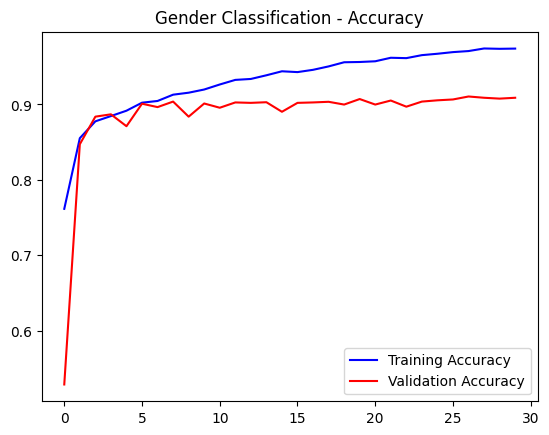

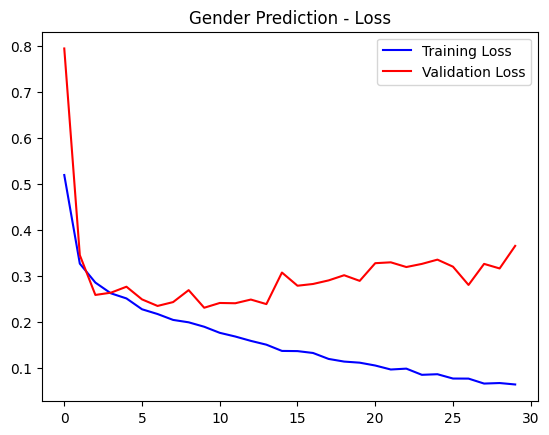

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Gender Classification - Accuracy')
plt.legend()
plt.figure()


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Gender Prediction - Loss')
plt.legend()
plt.show()

In [ ]:
valid_score = gender_model.evaluate(X_test, y_test_gender, verbose=1)

112/112 [==============================] - 1s 4ms/step - loss: 0.3655 - accuracy: 0.9089


In [ ]:
y_pred_gender = gender_model.predict(X_test[:500])
pred_classes = np.argmax(y_pred_gender,axis=1)

16/16 [==============================] - 0s 8ms/step


Accuracy: 0.536
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


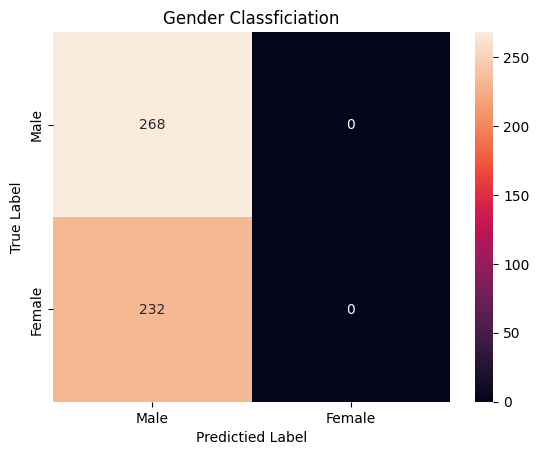

In [ ]:
evaluate_classification_model(y_test_gender.values[:500], pred_classes, ['Male', 'Female'])

In [ ]:
def predict_gender(label, img):
  gender_map = {0 : "Male", 1 : "Female"}

  print(f"Actual gender: {gender_map[label]}")

  m_prediction = gender_model.predict(img.reshape(-1,48,48, 1), verbose = 0)

  print(f"Predicted gender: {gender_map[np.argmax(m_prediction, axis = 1)[0]]}")

  return


pred = test.sample()
pred
predict_gender(pred.values[0][2], pred.values[0][3])
# test.iloc[0]

Actual gender: Male
Predicted gender: Male
